## Estudio del modelo $p-ARIMA-ANFIS$ para la serie estacionaria "airline-passengers" 

Importamos los paquetes necesarios

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA

Cargamos el conjunto de datos

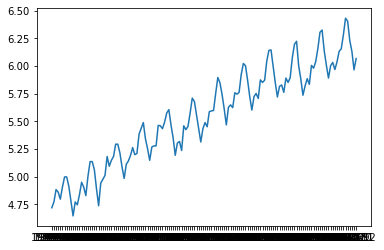

In [2]:
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv")
df.index = df["Month"]
del df["Month"]
df_log = np.log(df)
plt.plot(df_log)

Graficamos los datos

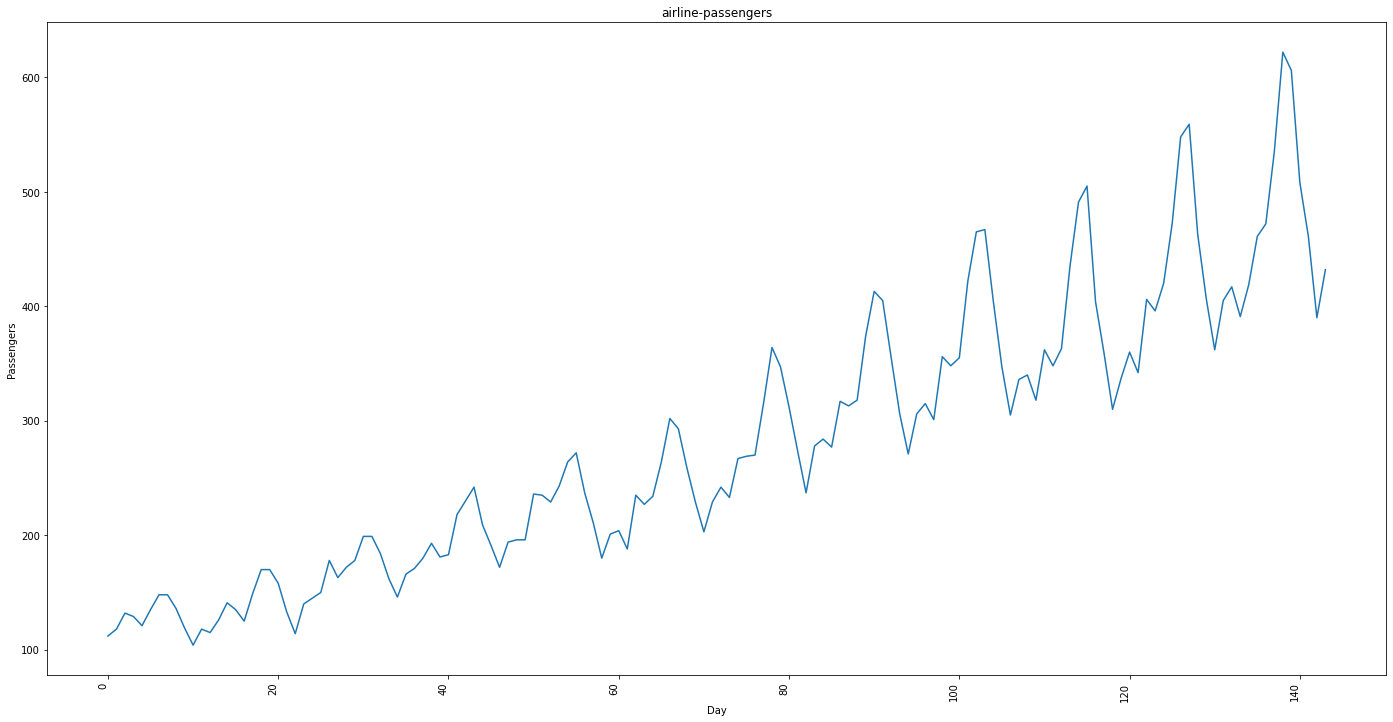

In [3]:
figure = plt.figure(figsize=(24,12))
plt.xticks(rotation=90, ha='right')
plt.title("airline-passengers")
plt.xlabel("Day")
plt.ylabel("Passengers")
plt.plot(range(len(df)), df)
plt.savefig("Passengers.png")
plt.show()

La data se ve que no es estacionaria. 

Determinamos el modelo ARIMA(2,1,2)

In [4]:
model = ARIMA(df_log, order=(2,1,2))
results = model.fit(disp=-1)
#plt.plot(results.fittedvalues, color='red')

/home/mag/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)
/home/mag/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  % freq, ValueWarning)


Graficamos el modelo ARIMA(2,1,2) junto con la serie original

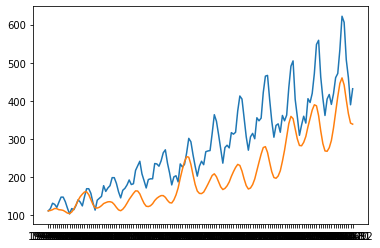

In [5]:
predictions_ARIMA_diff = pd.Series(results.fittedvalues, copy=True)
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()
predictions_ARIMA_log = pd.Series(df_log['Passengers'].iloc[0], index=df_log.index)
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum, fill_value=0)
predictions_ARIMA = np.exp(predictions_ARIMA_log)
plt.plot(df)
plt.plot(predictions_ARIMA)

Se define la métrica mean_absolute_percentage_error

In [6]:
def mean_absolute_percentage_error(y_true, y_pred): 


    ## Note: does not handle mix 1d representation
    #if _is_1d(y_true): 
    #    y_true, y_pred = _check_1d_array(y_true, y_pred)

    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

Definimos una función para hacer el desplazamiento de la serie para entrenar el modelo ANFIS y ANN

In [7]:
from pandas import DataFrame
from pandas import concat

def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
	"""
	Frame a time series as a supervised learning dataset.
	Arguments:
		data: Sequence of observations as a list or NumPy array.
		n_in: Number of lag observations as input (X).
		n_out: Number of observations as output (y).
		dropnan: Boolean whether or not to drop rows with NaN values.
	Returns:
		Pandas DataFrame of series framed for supervised learning.
	"""
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

Definimos el modelo ANFIS

In [8]:
class Anfis:

    def __init__(self, J=7, epoch=100, lr_1=0.5, lr_2=0.5):
        
        self.lr_1 = lr_1
        self.lr_2 = lr_2
        self.epoch = epoch
        self.J = J
        
        
    def f(self, j, X, t):
        return np.dot(np.concatenate((X[t],[1])),self.b[:,j])


    def mu(self, i, j, X, t):
        return np.exp(-((X[t][i]-self.m[i][j])/self.sigma[i][j])**2)

    def alfa(self,j, X, t):
        prod = 1
        for i in range(len(X[t])):
            prod *= self.mu(i,j, X, t) 
        
        return prod
    
    def train(self, X, Y):
        self.m = np.zeros((X.shape[1], self.J))
        self.sigma = np.ones((X.shape[1], self.J))
        self.b = np.ones((X.shape[1]+1, self.J))
        errores_salida = []
        for t in range(self.epoch):
            
            salida = []

            a = np.ones((X.shape[0], self.J))
            errores = []
            for i in range(X.shape[0]):

                for j in range(self.J):
                    summ = []
                    for k in range(j+1):
                        summ.append(self.alfa(k,X,i))

                    a[i][j] = self.alfa(j,X,i)/sum(summ)

                resultado = 0
                for j in range(self.J):
                    resultado += a[i][j]*self.f(j,X,i)

                salida.append(resultado)
                errores.append((resultado-Y[i])**2)
               

            p = []
            for i in range(X.shape[0]):
                s = np.concatenate(([1] ,X[i]))
                for j in range(1, self.J):
                    s = np.concatenate((s,np.concatenate(([1] ,X[i]))))
                s.reshape(self.J*(X.shape[1]+1))

                p.append(s)
            p = np.array(p) 

            Aux = np.ones((X.shape[0], self.J*(X.shape[1]+1)))

            for i in range(X.shape[0]):
                aux = np.full(X.shape[1]+1,a[0][0])
                for j in range(1, self.J):
                    aux = np.concatenate((aux,np.full(X.shape[1]+1,a[i][j])))
                Aux[i] = aux

            A = np.multiply(Aux,p)
            inverse = np.dot(A.T, A)
            if np.linalg.det(inverse)==0:        
                self.b = np.dot(np.linalg.pinv(inverse),np.dot(A.T,Y))
            else:
                self.b = np.dot(np.linalg.inv(inverse),np.dot(A.T,Y))
            self.b = self.b.reshape(X.shape[1]+1, self.J)
            

            derivada_m = np.zeros((X.shape[1], self.J))
            derivada_sigma = np.zeros((X.shape[1], self.J))

            for i in range(X.shape[1]):
                for j in range(self.J):
                    sum_m = 0
                    sum_sigma = 0
                    for v in range(X.shape[1]):
                        sum_m +=  (salida[v]-Y[v])*a[v][j]*((self.f(j,X,v)-Y[v])*(X[1][v]-self.m[i][j])/self.sigma[i][j]**2)
                        sum_sigma +=  (salida[v]-Y[v])*a[v][j]*((self.f(j,X,v)-Y[v])*(X[1][v]-self.m[i][j])**2/self.sigma[i][j]**3)
                    derivada_m[i][j] = 2/X.shape[0] * sum_m
                    derivada_sigma[i][j] = 2/X.shape[0] * sum_sigma


            for i in range(X.shape[1]):
                for j in range(self.J):
                    self.m[i][j] -= self.lr_1*derivada_m[i][j]
                    self.sigma[i][j] -= self.lr_2* derivada_sigma[i][j]
            
            errores_salida.append(sum(errores)/len(errores))
        return np.array(errores_salida)
    
    def predict(self, X):
        
        salida = []

        a = np.ones((X.shape[0], self.J))
        errores = []
        for i in range(X.shape[0]):

            for j in range(self.J):
                summ = []
                for k in range(j+1):
                    summ.append(self.alfa(k,X,i))

                a[i][j] = self.alfa(j,X,i)/sum(summ)

            resultado = 0
            for j in range(self.J):
                resultado += a[i][j]*self.f(j,X,i)

            salida.append(resultado)
            
        return np.array(salida)

Aplicamos el desplazamiento de la serie a 3 valores y redefinimos las columnas

In [9]:
df_anfis = series_to_supervised(df, n_out=3)
df_anfis.rename(columns={"var1(t-1)":"t", "var1(t)":"t+1", "var1(t+1)":"t+2", "var1(t+2)":"t+3"}, inplace=True)
df_anfis

,t,t+1,t+2,t+3
Month,,,,
1949-02,112.0,118,132.0,129.0
1949-03,118.0,132,129.0,121.0
1949-04,132.0,129,121.0,135.0
1949-05,129.0,121,135.0,148.0
1949-06,121.0,135,148.0,148.0
...,...,...,...,...
1960-06,472.0,535,622.0,606.0
1960-07,535.0,622,606.0,508.0
1960-08,622.0,606,508.0,461.0


Definimos X, Y y aplicamos escalamiento estandar

In [10]:


X = df_anfis[["t", "t+1", "t+2"]].values
Y = df_anfis["t+3"].values


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X = scaler.fit_transform(X)


Instanciamos y entrenamos el modelo ANFIS

In [11]:
model2 = Anfis(J=5, epoch=20, lr_1=0.5, lr_2=0.5)
n = 119
errores_anfis = model2.train(X[:n],Y[:n])
errores_anfis

array([7.06154680e+04, 9.93976415e+04, 4.52140641e+17, 1.07652788e+16,
       1.07108215e+21, 1.87168581e+20, 1.45066458e+23, 9.48932543e+25,
       8.58272958e+04, 8.58272958e+04, 8.58272958e+04, 8.58272958e+04,
       8.58272958e+04, 8.58272958e+04, 8.58272958e+04, 8.58272958e+04,
       8.58272958e+04, 8.58272958e+04, 8.58272958e+04, 8.58272958e+04])

Se define el modelo  𝑝− ARIMA-ANFIS como la combinación convexa de ARIMA mas una transformación lineal de la predicción del ANFIS

In [12]:
p = 0.2
combinado = p * predictions_ARIMA[3:-3] + (1-p) * model2.predict(X)[3:]*0.8 + 260

In [13]:
print(mean_absolute_percentage_error(Y[:-3], model2.predict(X[3:])*0.8 + 260))
print(mean_absolute_percentage_error(Y[:-3], predictions_ARIMA[3:-3]))
print(mean_absolute_percentage_error(Y[:-3], combinado))

5.439960048623755
25.76416806976818
13.526185790491265


Definimos una red neuronal para comparar resultados

In [14]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

np.random.seed(10)


# create and fit the LSTM network
model3 = Sequential()
model3.add(Dense(8, input_shape=X[:n].shape))
model3.add(Dense(5))
model3.add(Dense(3))
model3.add(Dense(1))
model3.compile(loss='mean_squared_error', optimizer='adam')
errores_ann = model3.fit(X[:n], Y[:n], epochs=200)

Epoch 1/200
4/4 [==============================] - 0s 4ms/step - loss: 71703.8828
Epoch 2/200
4/4 [==============================] - 0s 4ms/step - loss: 71687.9219
Epoch 3/200
4/4 [==============================] - 0s 2ms/step - loss: 71672.6875
Epoch 4/200
4/4 [==============================] - 0s 2ms/step - loss: 71657.2109
Epoch 5/200
4/4 [==============================] - 0s 2ms/step - loss: 71641.4219
Epoch 6/200
4/4 [==============================] - 0s 3ms/step - loss: 71625.4375
Epoch 7/200
4/4 [==============================] - 0s 2ms/step - loss: 71608.9219
Epoch 8/200
4/4 [==============================] - 0s 2ms/step - loss: 71592.2109
Epoch 9/200
4/4 [==============================] - 0s 2ms/step - loss: 71574.6719
Epoch 10/200
4/4 [==============================] - 0s 2ms/step - loss: 71555.8672
Epoch 11/200
4/4 [==============================] - 0s 3ms/step - loss: 71536.3828
Epoch 12/200
4/4 [==============================] - 0s 2ms/step - loss: 71516.0781
Epoch 13/200


4/4 [==============================] - 0s 3ms/step - loss: 1030.8363
Epoch 193/200
4/4 [==============================] - 0s 3ms/step - loss: 1026.3562
Epoch 194/200
4/4 [==============================] - 0s 5ms/step - loss: 1020.2846
Epoch 195/200
4/4 [==============================] - 0s 4ms/step - loss: 1016.2216
Epoch 196/200
4/4 [==============================] - ETA: 0s - loss: 1274.75 - 0s 3ms/step - loss: 1011.9697
Epoch 197/200
4/4 [==============================] - 0s 3ms/step - loss: 1009.4243
Epoch 198/200
4/4 [==============================] - 0s 5ms/step - loss: 1002.9772
Epoch 199/200
4/4 [==============================] - 0s 4ms/step - loss: 997.1661
Epoch 200/200
4/4 [==============================] - 0s 2ms/step - loss: 994.3052


Primera métrica: mean_absolute_percentage_error

In [15]:
print(mean_absolute_percentage_error(Y[n:-3], combinado[n:]))
print(mean_absolute_percentage_error(Y[n:-3], predictions_ARIMA[n+3:-3]))
print(mean_absolute_percentage_error(Y[n:-3], model3.predict(X[n:-3])))

1.7713722528460554
23.267715998054562
16.81893865623028


Segunda métrica: mean_absolute_error

In [16]:
from sklearn.metrics import mean_absolute_error
print(mean_absolute_error(Y[n:-3], combinado[n:]))
print(mean_absolute_error(Y[n:-3], predictions_ARIMA[n+3:-3]))
print(mean_absolute_error(Y[n:-3], model3.predict(X[n:-3])))

8.589533314824568
109.65474630544433
54.666413959703945


Tercera métrica: mean_squared_error

In [17]:
from sklearn.metrics import mean_squared_error
print(mean_squared_error(Y[n:-3], combinado[n:]))
print(mean_squared_error(Y[n:-3], predictions_ARIMA[n+3:-3]))
print(mean_squared_error(Y[n:-3], model3.predict(X[n:-3])))

125.87421296811047
13806.750023712946
3789.804250134743


Gráfica de las predicciones

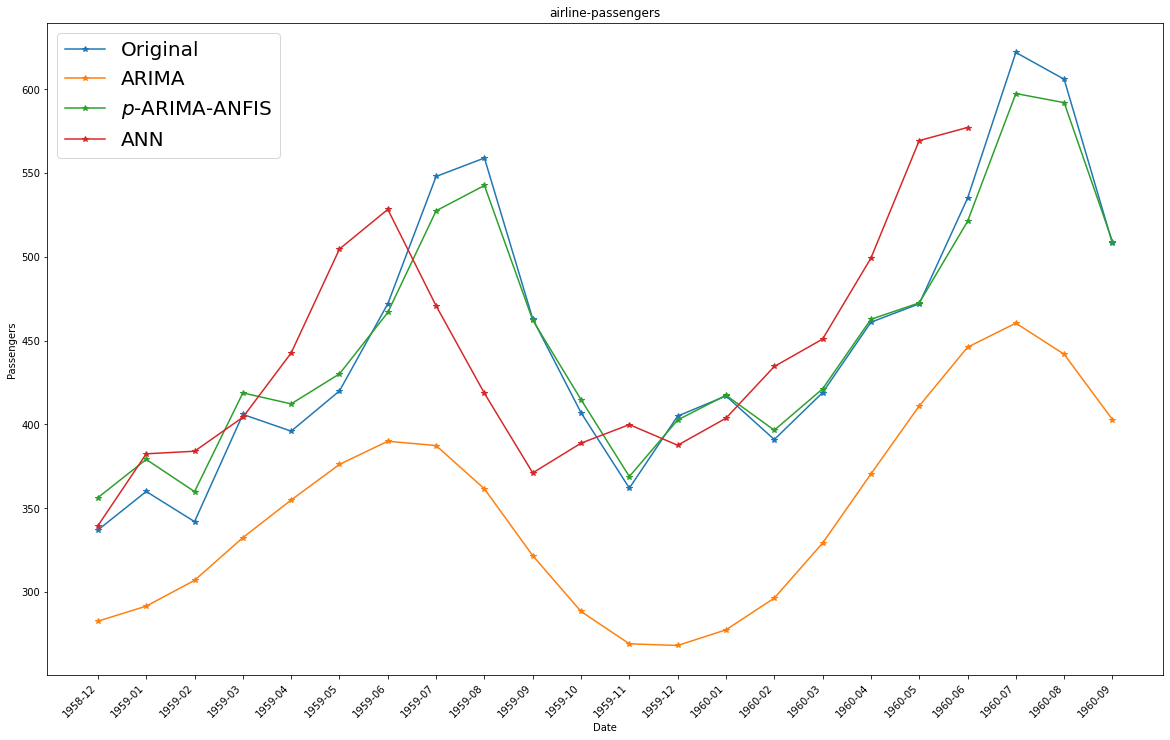

In [18]:
figure = plt.figure(figsize=(20,12))
plt.title("airline-passengers")
plt.xticks(rotation=45, ha='right')
plt.xlabel("Date")
plt.ylabel("Passengers")
plt.plot(df["Passengers"][n:-3],"-*", label="Original")
plt.plot(predictions_ARIMA[n:-3],"-*", label="ARIMA")
plt.plot(combinado[n-3:], "-*", label="$p$-ARIMA-ANFIS")
plt.plot(model3.predict(X[n:-3]).reshape(1,-1)[0], "-*", label="ANN")
plt.legend(loc = 'best', prop={'size': 20})
plt.savefig("figura2.png")
plt.show()